# Multiclass classification

Neural Networks are often used to classify data. Examples are neural networks:
- take in photos and classify subjects in the photos as {dog,cat,horse,other}
- take in a sentence and classify the 'parts of speech' of its elements: {noun, verb, adjective etc..}  

A network of this type will have multiple units in its final layer. Each output is associated with a category. When an input example is applied to the network, the output with the highest value is the category predicted. If the output is applied to a softmax function, the output of the softmax will provide probabilities of the input being in each category. 

In this lab you will see an example of building a multiclass network in Tensorflow. We will then take a look at how the neural network makes its predictions.

Let's start by creating a four-class data set.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
np.set_printoptions(precision=2)

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [7]:
# Helper functions
#from lab_utils_multiclass_TF import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import warnings
from matplotlib import cm
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

from matplotlib import cm

#from lab_utils_common import dlc


dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
plt.style.use('../deeplearning.mplstyle')

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

#Plot a multi-class categorical decision boundary
# This version handles a non-vector prediction (adds a for-loop over points)
def plot_cat_decision_boundary_mc(ax, X, predict , class_labels=None, legend=False, vector=True):

    # create a mesh to points to plot
    x_min, x_max = X[:, 0].min()- 0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()- 0.5, X[:, 1].max()+0.5
    h = max(x_max-x_min, y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #print("xx.shape", xx.shape)

    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, linewidths=1) 
    #ax.axis('tight')

      
def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, 
                legend=False, size=50, m='o', equal_xy = False):
    """ Plot multiclass data. Note, if equal_xy is True, setting ylim on the plot may not work """
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        # this didn't work on coursera but did in local version
        #ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
        #            c=col, vmin=0, vmax=map.N, cmap=map,
        #            s=size, label=label)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    color=map(col), vmin=0, vmax=map.N, 
                    s=size, label=label)
    if legend: ax.legend()
    if equal_xy: ax.axis("equal")

def plt_mc(X_train,y_train,classes, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax, X_train,y_train,classes, map=dkcolors_map, legend=True, size=50, equal_xy = False)
    ax.set_title("Multiclass Data")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    #for c in css:
    #    circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
    #    ax.add_patch(circ)
    plt.show()

def plt_cat_mc(X_train, y_train, model, classes):
    #make a model for plotting routines to call
    model_predict = lambda Xl: np.argmax(model.predict(Xl),axis=1)

    fig,ax = plt.subplots(1,1, figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
 
    #add the original data to the decison boundary
    plt_mc_data(ax, X_train,y_train, classes, map=dkcolors_map, legend=True)
    #plot the decison boundary. 
    plot_cat_decision_boundary_mc(ax, X_train, model_predict, vector=True)
    ax.set_title("model decision boundary")

    plt.xlabel(r'$x_0$');
    plt.ylabel(r"$x_1$"); 
    plt.show()

    
def plt_prob_z(ax,fwb, x0_rng=(-8,8), x1_rng=(-5,4)):
    """ plots a decision boundary but include shading to indicate the probability
        and adds a conouter to show where z=0
    """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(x0_rng[0], x0_rng[1], 40)
    x1_space  = np.linspace(x1_rng[0], x1_rng[1], 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    c = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)
            c[i,j] = 0. if z[i,j] == 0 else 1.
    with warnings.catch_warnings():  # suppress no contour warning
        warnings.simplefilter("ignore")
        #ax.contour(tmp_x0, tmp_x1, c, colors='b', linewidths=1) 
        ax.contour(tmp_x0, tmp_x1, c, linewidths=1) 

    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.7)

    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=np.amin(z), vmax=np.amax(z)),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def plt_layer_relu(X, Y, W1, b1, classes):
    nunits = (W1.shape[1])
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(7,2.5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    for i in range(nunits):
        layerf= lambda x : np.maximum(0,(np.dot(x,W1[:,i]) + b1[i]))
        plt_prob_z(ax[i], layerf)
        plt_mc_data(ax[i], X, Y, classes, map=dkcolors_map,legend=True, size=50, m='o')
        ax[i].set_title(f"Layer 1 Unit {i}")
        ax[i].set_ylabel(r"$x_1$",size=10)
        ax[i].set_xlabel(r"$x_0$",size=10)
    fig.tight_layout()
    plt.show()


def plt_output_layer_linear(X, Y, W, b, classes, x0_rng=None, x1_rng=None):
    nunits = (W.shape[1])
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(2,int(nunits/2), figsize=(7,5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    for i,axi in enumerate(ax.flat):
        layerf = lambda x : np.dot(x,W[:,i]) + b[i]
        plt_prob_z(axi, layerf, x0_rng=x0_rng, x1_rng=x1_rng)
        plt_mc_data(axi, X, Y, classes, map=dkcolors_map,legend=True, size=50, m='o')
        axi.set_ylabel(r"$a^{[1]}_1$",size=9)
        axi.set_xlabel(r"$a^{[1]}_0$",size=9)
        axi.set_xlim(x0_rng)
        axi.set_ylim(x1_rng)
        axi.set_title(f"Linear Output Unit {i}")
    fig.tight_layout()
    plt.show()



### Generate a 4-class data

<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


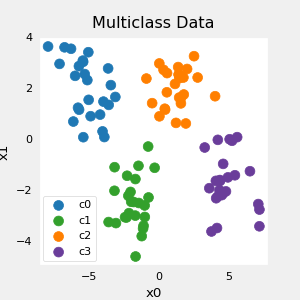

In [8]:
classes = 4
m = 100
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std,random_state=30)

plt_mc(X_train,y_train,classes, centers, std=std)

Each dot represents a training example. The axis (x0,x1) are the inputs and the color represents the class the example is associated with. Once trained, the model will be presented with a new example, (x0,x1), and will predict the class.  

While generated, this data set is representative of many real-world classification problems. There are several input features (x0,...,xn) and several output categories. The model is trained to use the input features to predict the correct output category.

In [9]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show how classes are represented
print(f"class representation {y_train[:10]}")
# show shapes of our dataset
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2 3]
class representation [3 3 3 0 3 3 3 3 2 0]
shape of X_train: (100, 2), shape of y_train: (100,)


## Model

This is a 2-layer network. Unlike the binary classification networks, this network has four outputs, one for each class. Given an input example, the output with the highest value is the predicted class of the input.   

Notice the output layer uses a `linear` rather than a `softmax` activation. While it is possible to include the softmax in the output layer, it is more numerically stable if linear outputs are passed to the loss function during training. If the model is used to predict probabilities, the softmax can be applied at that point. 

Setting `from_logits=True` as an argument to the loss function specifies that the output activation was linear rather than a softmax.

In [10]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        Dense(2, activation = 'relu',   name = "L1"),
        Dense(4, activation = 'linear', name = "L2")
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

model.fit(
    X_train,y_train,
    epochs=200
)

Epoch 1/200
4/4 [==============================] - 1s 8ms/step - loss: 3.8014
Epoch 2/200
4/4 [==============================] - 0s 3ms/step - loss: 3.4220
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 3.0856
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 2.7838
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 2.5323
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 2.2591
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 2.0443
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 1.8436
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 1.6794
Epoch 10/200
4/4 [==============================] - 0s 1ms/step - loss: 1.5067
Epoch 11/200
4/4 [==============================] - 0s 3ms/step - loss: 1.3762
Epoch 12/200
4/4 [==============================] - 0s 3ms/step - loss: 1.2653
Epoch 13/200
4/4 [==============================] - 0s 2ms/st

### Here is the classification based on the model

103/184 [===============>..............] - ETA: 0s

<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


184/184 [==============================] - 0s 858us/step


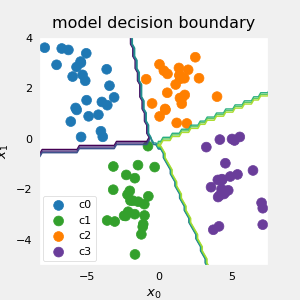

In [11]:
plt_cat_mc(X_train, y_train, model, classes)

Above, the decision boundaries show how the model has partitioned the input space.  This very simple model has had no trouble classifying the training data. How did it accomplish this? Let's look at the network in more detail. 

Below, we will pull the trained weights from the model and use that to plot the function of each of the network units. Further down, there is a more detailed explanation of the results. You don't need to know these details to successfully use neural networks, but it may be helpful to gain more intuition about how the layers combine to solve a classification problem.

<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


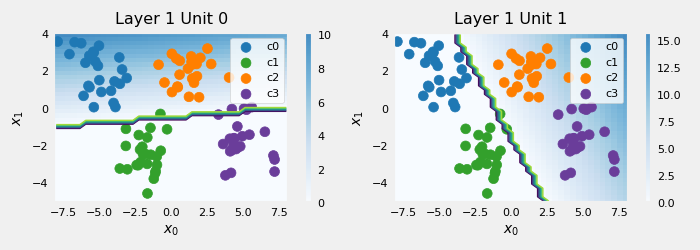

In [13]:
# gather the trained parameters from the first layer
l1 = model.get_layer("L1")
W1,b1 = l1.get_weights()

# plot the function of the first layer
plt_layer_relu(X_train, y_train.reshape(-1,), W1, b1, classes)

<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
<ipython-input-7-440d573fe297>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


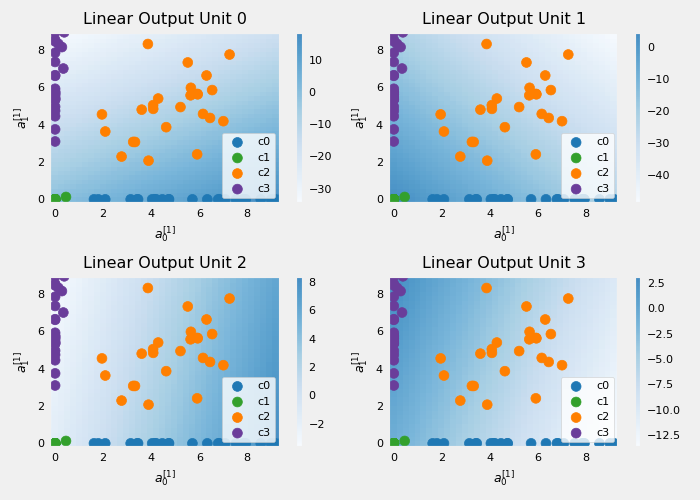

In [14]:
# gather the trained parameters from the output layer
l2 = model.get_layer("L2")
W2, b2 = l2.get_weights()
# create the 'new features', the training examples after L1 transformation
Xl2 = np.maximum(0, np.dot(X_train,W1) + b1)

plt_output_layer_linear(Xl2, y_train.reshape(-1,), W2, b2, classes,
                        x0_rng = (-0.25,np.amax(Xl2[:,0])), x1_rng = (-0.25,np.amax(Xl2[:,1])))

## Explanation

These plots show the function of Units 0 and 1 in the first layer of the network. The inputs are ($x_0,x_1$) on the axis. The output of the unit is represented by the color of the background. This is indicated by the color bar on the right of each graph. Notice that since these units are using a ReLu, the outputs do not necessarily fall between 0 and 1 and in this case are greater than 20 at their peaks. 
The contour lines in this graph show the transition point between the output, $a^{[1]}_j$ being zero and non-zero. Recall the graph for a ReLu :<img align="right" src="./images/C2_W2_mclass_relu.png"  style=" width:200px; padding: 10px 20px ; "> The contour line in the graph is the inflection point in the ReLu.

Unit 0 has separated classes 0 and 1 from classes 2 and 3. Points to the left of the line (classes 0 and 1) will output zero, while points to the right will output a value greater than zero.  
Unit 1 has separated classes 0 and 2 from classes 1 and 3. Points above the line (classes 0 and 2 ) will output a zero, while points below will output a value greater than zero. Let's see how this works out in the next layer!


#### Layer 2, the output layer  

The dots in these graphs are the training examples translated by the first layer. One way to think of this is the first layer has created a new set of features for evaluation by the 2nd layer. The axes in these plots are the outputs of the previous layer $a^{[1]}_0$ and $a^{[1]}_1$. As predicted above, classes 0 and 1 (blue and green) have  $a^{[1]}_0 = 0$ while classes 0 and 2 (blue and orange) have $a^{[1]}_1 = 0$.  
Once again, the intensity of the background color indicates the highest values.  
Unit 0 will produce its maximum value for values near (0,0), where class 0 (blue) has been mapped.    
Unit 1 produces its highest values in the upper left corner selecting class 1 (green).  
Unit 2 targets the lower right corner where class 2 (orange) resides.  
Unit 3 produces its highest values in the upper right selecting our final class (purple).  

One other aspect that is not obvious from the graphs is that the values have been coordinated between the units. It is not sufficient for a unit to produce a maximum value for the class it is selecting for, it must also be the highest value of all the units for points in that class. This is done by the implied softmax function that is part of the loss function (`SparseCategoricalCrossEntropy`). Unlike other activation functions, the softmax works across all the outputs.

You can successfully use neural networks without knowing the details of what each unit is up to. Hopefully, this example has provided some intuition about what is happening under the hood.
